This notebook maps rice landcover in Cambodia and Laos. It also maps the irrigated areas on the same area, as well as irrigated rice areas. Functions used for raster processing can be found from Functions.ipynb. Data sources are:
1) Landcover rasters of Cambodia and Laos: https://www.landcovermapping.org/en/landcover/#
2) Irrigation raster (G_AEI_2015.asc): https://zenodo.org/record/6886564#.YxBdCnZBxPZ
3) East-Asia boundaries: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/

In this notebook there is a lot of writing new rasters to file, since I was also practising working with rasters during this whole exercise. With more practice (and maybe even now after doing this), I think this could be mostly avoided.

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from pyproj import CRS
import contextily as ctx
from rasterio.warp import calculate_default_transform, reproject, Resampling
pip install ipynb
import ipynb.fs.defs.Final_functions
import xarray as xr
import glob
import math

In [2]:
# Reading the world boundary shp from: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/
# Creating gdf and selecting only Camboda and Laos
dirpath = os.path.join(os.getcwd(),'data')
fp = os.path.join(dirpath,'shp/world-administrative-boundaries.shp')
poly = gpd.read_file(fp)
# selecting based on column "color_code" where Cambodia is KHM and Laos is LAO
selection = poly.loc[(poly['color_code'] == 'KHM') | (poly['color_code'] == 'LAO')]
Laos_gdf = selection.loc[selection['color_code'] == 'LAO']
Cam_gdf = selection.loc[selection['color_code'] == 'KHM']
# combining the geometries for later plotting
union = selection.unary_union
# Bounding box used for cropping mosaics
bbox = gpd.GeoDataFrame({'geometry' : union}, index=[0], crs='epsg:4326')
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
Cam_Lao_coords = getFeatures(bbox)
Cam_coords = getFeatures(Cam_gdf)
Lao_coords = getFeatures(Laos_gdf)

In [3]:
# Crs transformation for calculating areas for possible country statistics
Lao_cam_gdf = bbox.copy()
Lao_cam_gdf = Lao_cam_gdf.to_crs(8859)
Laos_gdf = Laos_gdf.to_crs(8859)
Cam_gdf = Cam_gdf.to_crs(8859)
# Areas for Cambodia and Laos
Lao_cam_gdf['area_km^2'] = Lao_cam_gdf.area/1000000
Laos_gdf['area_km^2'] = Laos_gdf.area/1000000
Cam_gdf['area_km^2']= Cam_gdf.area/1000000
Lao_cam_gdf = Lao_cam_gdf.to_crs(4326)
Laos_gdf = Laos_gdf.to_crs(4326)
Cam_gdf = Cam_gdf.to_crs(4326)

In [4]:
# Importing defined functions
from ipynb.fs.full.Final_functions import create_mosaic, clip_raster, align_to_raster, get_rice

In [5]:
# Let's start by clipping the landcover rasters
clip_raster('landcover_laos.tif', Lao_coords, 'Clipped_Laos.tif')
clip_raster('landcover_Cambodia.tif', Cam_coords, 'Clipped_Cambodia.tif')

In [6]:
# Creating mosaic from clipped rasters
create_mosaic('Cam_Lao_Mosaic.tif')

In [7]:
# Clipping the irrigation raster.
clip_raster('G_AEI_2015.asc', Cam_Lao_coords, 'Clipped_irrigation.tif')

In [8]:
# Aligning the irrigation raster to the more accurate land cover mosaic
# align_to_raster takes as input: to which raster to align to, raster to reproject, new raster name
align_to_raster('Cam_Lao_Mosaic.tif', 'clipped_irrigation.tif', 'aligned_irrigation.tif')

In [9]:
# Getting the rice-landcover from mosaic. Input raster, output name.
get_rice('Cam_Lao_mosaic.tif', 'Rice_Mosaic.tif')

Next we are going to calculate the average irrigation % for each grid cell. As the irrigation raster is in 5 arcmin resolution, the maximum possible values are ~ 8574ha (9.260km^2 * 100). As the irrigation raster values range up to 7542, they are as HA. For the area calculus we are using formula 9.26km^2 * cos(lat/360 * 2 * pi)

In [10]:
# Max area discussed
print(9.260**2*100)

8574.759999999998


In [11]:
fp_irri = os.path.join(dirpath,'Clipped_irrigation.tif')
irrigation = xr.open_dataset(fp_irri)

In [12]:
# Looping through all latitudes to get more precise areas
for i in irrigation.y:
    irrigation['percentage'] = (irrigation.band_data/100)/(9.260**2*math.cos(i/360*math.pi*2))

In [13]:
# Converting irrigation to array so we can rewrite it with previously written code.
irrigation = irrigation.to_array(dim='variable', name='irrigation')

In [14]:
# Writing irrigation raster to file so we can align it later. This could probably be done in one step
data = rasterio.open( os.path.join(dirpath,'Clipped_irrigation.tif'))
out_meta = data.meta.copy()
with rasterio.open(
    os.path.join(dirpath, 'irrigation_as_percentage.tif'),
        mode="w",
        **out_meta) as new_dataset:
        new_dataset.write(irrigation[1])

In [15]:
# Similar as align to raster, but also reprojecting correctly. (Still not exactly the end result I was aiming for)
dirpath = os.path.join(os.getcwd(),'data')
fp2 = os.path.join(dirpath,'irrigation_as_percentage.tif')
fp1 = os.path.join(dirpath,'Cam_Lao_Mosaic.tif')
tiffname = os.path.join(dirpath, 'aligned_percentage.tif')
dst_crs = 4326

with rasterio.open(fp2) as src:
        src_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
# shape from source height and width, data input from raster irrigation_as_percentage
src_shape = (height, width)
data= rasterio.open(fp2)
array = data.read()
source = rasterio.band(data, 1)

with rasterio.open(fp1) as dst:
        dst_transform, width, height = calculate_default_transform(
            dst.crs, dst_crs, dst.width, dst.height, *dst.bounds)
        out_meta = dst.meta.copy()
        out_meta.update({
            'crs': dst_crs,
            'transform': dst_transform,
             'width': width,
            'height': height})
dst_shape = (height,width)
data2= rasterio.open(fp1)
destination=rasterio.band(data2, 1)
with rasterio.open(tiffname, 'w', **out_meta) as dst:
        reproject(
            source=rasterio.band(rasterio.open(fp2), 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=src.transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

In [16]:
# Creating a new raster from irrigation and rice-landcover raster to calculate the % of irrigated rice areas
fp_rice = os.path.join(dirpath, 'Rice_Mosaic.tif')
rice = xr.load_dataset(fp_rice)
fp_irrigation = os.path.join(dirpath, 'aligned_percentage.tif')
irrigation_percentage = xr.open_dataset(fp_irrigation)
rice_percentage = irrigation_percentage.copy()
rice_percentage['percentage'] = irrigation_percentage.band_data * rice.band_data

In [17]:
# Reading rest of the rasters, rice and irrigation already open
fp = os.path.join(dirpath, 'Cam_Lao_Mosaic.tif')
landcover = xr.load_dataset(fp)

In [18]:
# Raster to be used: landcover, irrigation_percentage, rice_percentage, rice

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

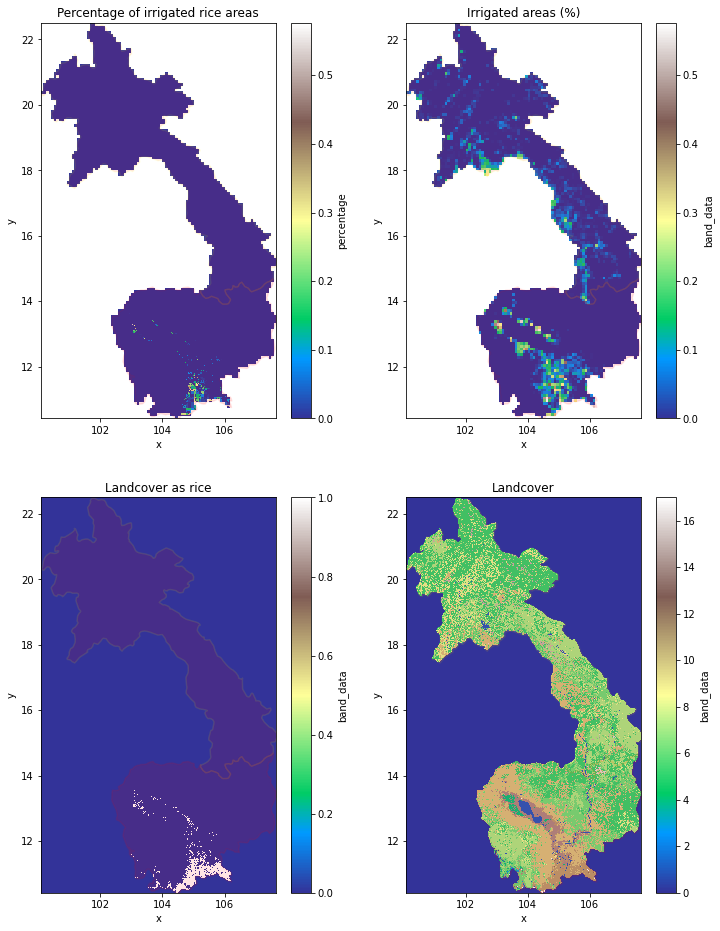

In [37]:
# Plotting all rasters
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(12,16))

#ax[0,0].set_xlabel('Longitude')
#ax[0,0].set_ylabel('Latitude')



rice_percentage.percentage.plot(ax =  ax[0,0], cmap='terrain')
rice.band_data.plot(ax = ax[1,0], cmap='terrain')
irrigation_percentage.band_data.plot(ax = ax[0,1], cmap='terrain')
landcover.band_data.plot(ax = ax[1,1], cmap='terrain')

i= 0
j= 0
for i in range(2):
    for j in range(2):
        Cam_gdf.plot(ax = ax[i,j], facecolor='red',alpha= 0.1, edgecolor='red', linewidth=1.5)
        Laos_gdf.plot(ax = ax[i,j], facecolor='red',alpha= 0.1, edgecolor='yellow', linewidth=1.5)
#        ax[i,j].set_xlabel('Longitude')
#        ax[i,j].set_ylabel('Latitude')
        j +=1
    i +=1
ax[0,0].set_title('Percentage of irrigated rice areas')
ax[1,0].set_title('Landcover as rice')
ax[0,1].set_title('Irrigated areas (%)')
ax[1,1].set_title('Landcover')
plt.tight_layout


Since we found out from exernal sources during this exercise that the rice-landcover in Laos is defined as "cropland", I will perform statistics analysis and more pleasant plotting only for Cambodia area.

In [19]:
clip_raster('aligned_percentage.tif', Cam_coords, 'irrigation_Cam.tif')


In [20]:
get_rice('Clipped_Cambodia.tif', 'Rice_Cambodia.tif')

In [21]:
align_to_raster('Clipped_Cambodia.tif', 'irrigation_Cam.tif', 'Cam_aligned.tif')

In [22]:
# Reading the Cambodia rasters
irrigation_Cam = xr.load_dataset(os.path.join(dirpath, 'Cam_aligned.tif'))
rice_Cam = xr.load_dataset(os.path.join(dirpath, 'Rice_Cambodia.tif'))
lc_Cam = xr.load_dataset('data/Clipped_Cambodia.tif')


In [23]:
# Calculating percentage of irrigated areas with rice landcover
rice_percentage_Cam = irrigation_Cam.copy()
rice_percentage_Cam['percentage'] = irrigation_Cam.band_data * rice_Cam.band_data

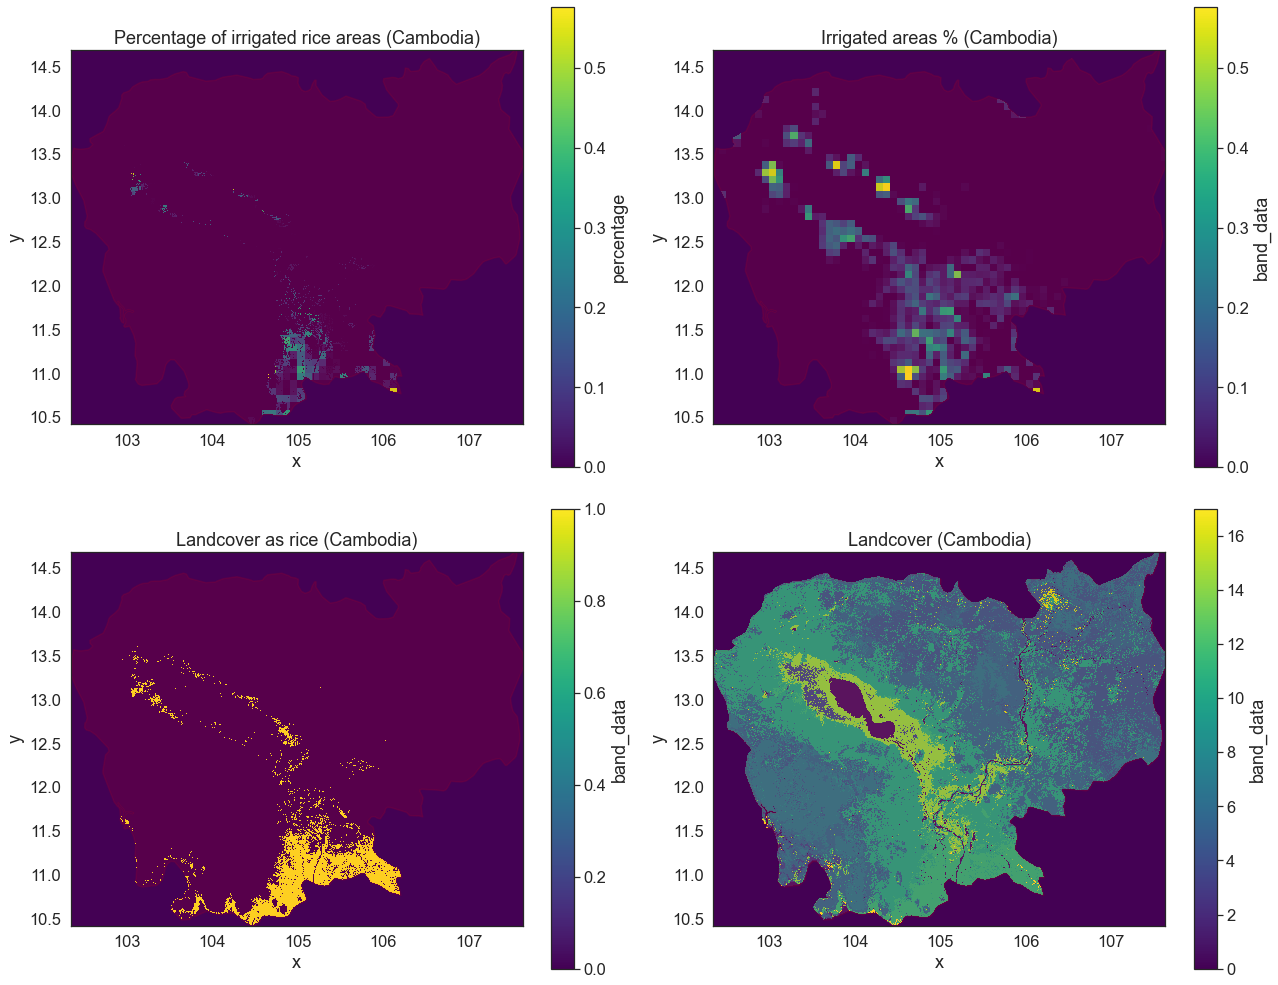

In [25]:
# Plotting the rasters for Cambodia
import seaborn as sns
sns.set(font_scale=1.5, style="white")
out_img = 'Cambodia.png'
fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(18,14))

ax[0,0].set_xlabel('Longitude')
ax[0,0].set_ylabel('Latitude')

# Filling the nan values for percentages of irrigated areas since there was some problems with aligning
rice_percentage_Cam.percentage.fillna(0).plot(ax=ax[0,0])
irrigation_Cam.band_data.fillna(0).plot(ax=ax[0,1])
rice_Cam.band_data.plot(ax=ax[1,0])
lc_Cam.band_data.plot(ax=ax[1,1])
for i in range(2):
    for j in range(2):
        Cam_gdf.plot(ax = ax[i,j], facecolor='red',alpha= 0.1, edgecolor='red', linewidth=1.5)
        j +=1
    i +=1
ax[0,0].set_title('Percentage of irrigated rice areas (Cambodia)')
ax[1,0].set_title('Landcover as rice (Cambodia)')
ax[0,1].set_title('Irrigated areas % (Cambodia)')
ax[1,1].set_title('Landcover (Cambodia)')

plt.tight_layout()
plt.savefig(out_img, dpi=800)

Calculating zonal statistics for rice, irrigation and irrigation as rice

In [26]:
irrigated_rice_Cam = rice_percentage_Cam.to_array(dim='variable', name='irrigation')

In [27]:
# Writing irrigation raster to file so we can align it later. This could probably be done in one step
out_meta = data.meta.copy()
with rasterio.open(
    os.path.join(dirpath, 'rice_per_Cam.tif'),
        mode="w",
        **out_meta) as new_dataset:
        new_dataset.write(irrigated_rice_Cam[1])

In [28]:
data =rasterio.open(os.path.join(dirpath, 'Cam_aligned.tif'))
irri_Cam = data.read(1)
data1 = rasterio.open(os.path.join(dirpath, 'Rice_Cambodia.tif'))
rice_Cam = data1.read(1)
data2 = rasterio.open(os.path.join(dirpath, 'rice_per_Cam.tif'))
rice_per_Cam = data2.read(1)

In [29]:
affine = data.transform
affine_rice= data1.transform
affine_rice_per = data2.transform

In [31]:
zonal_irrigation = zonal_stats(Cam_gdf, irri_Cam, affine=affine,
            stats="count mean max")
zonal_rice = zonal_stats(Cam_gdf, rice_Cam, affine=affine_rice,
            stats="count mean max")
zonal_rice_per = zonal_stats(Cam_gdf, rice_per_Cam, affine=affine_rice_per,
            stats="count mean max")

C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [32]:
print(zonal_irrigation)

[{'max': 0.5761610865592957, 'mean': 0.022018070156363187, 'count': 3502975}]


In [33]:
print(zonal_rice)

[{'max': 1.0, 'mean': 0.05824709292235555, 'count': 3543679}]


In [34]:
print(zonal_rice_per)

[{'max': 0.5400309562683105, 'mean': 0.012919051637265951, 'count': 2163}]


From these we are interested mostly on the mean values. The count differencies are explained by the pixels on the borders of Cambodia that are left as nan in irrigation stats. 
So from the mean values we can see that the average landcover as rice is 5,8%, while 2,2% of the whole area of Cambodia is irrigated and 0,4% are irrigated with rice.

I would have expected more of the irrigated areas being rice, since it's the main crop grown in Cambodia. This may be a bit errorous result, which probably is caused by the reprojecting between different spatial resolution, which I found being difficult.